# Učitavanje biblioteka za rad 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

random.seed(1)

In [2]:
# broj indeksa za studenta Jovan Dmitrović
ind = '2021/3096'

# odredjivanje algoritama koje je potrebno implementirati
B3 = int(ind[-2])
B4 = int(ind[-1])

even_num = lambda num: True if num%2 == 0 else False

algos_dict = {(False, False): ['Softmax logisticka regresija', 'Gauss-ovski naivni Bayes'],
             (False, True) : ['Softmax logisticka regresija', 'Gauss-ovska diskriminativna analiza'],
             (True, False) : ['Logisticka regresija', 'Gauss-ovski naivni Bayes'],
             (True, True)  : ['Logisticka regresija', 'Gauss-ovska diskriminativna analiza']}

algos_selected = algos_dict[(even_num(B3), even_num(B4))]

print(f'Na osnovu broja indeksa, potrebno je implementirati sledeca 2 algoritma: \n - {algos_selected[0]} i \n - {algos_selected[1]}')

Na osnovu broja indeksa, potrebno je implementirati sledeca 2 algoritma: 
 - Softmax logisticka regresija i 
 - Gauss-ovska diskriminativna analiza


# Učitavanje podataka 

In [3]:
def get_classes_info(y: np.ndarray, show_text: bool=True) -> int:
    
    """
        Funkcija za izvlacenje klasa i prebrojavanja primera
        sa istom klasom
        
        params: 
            - y: vektor klasa
                               
        :return:
            - k: broj klasa
    """
    # dohvatanje svih vrednosti klasa
    classes = []
    for _class in y:
        if _class not in classes:
            classes.append(int(_class))
            
    # prebrojavanje predstavnika klasa
    classes_dict = dict.fromkeys(classes)
    for _class in classes:
        class_count = np.count_nonzero(y == _class)
        classes_dict[_class] = class_count
        
    # broj klasa
    k = len(classes_dict.keys())
        
    # ispis podataka o klasama u dataset-u
    if show_text:
        print('-------------------------------------------------------')
        print(f'Ukupan broj klasa kojima pripadaju ucitani primeri je: {k}\n')
        print('Ucitane klase i brojevi njhovih predstavnika/primera su: ')
        for _class in classes_dict.keys():
            print(f'\tKlasa {_class}: {classes_dict[_class]} primera')
        print('-------------------------------------------------------')
    
    return k

In [4]:
data = pd.read_csv('multiclass_data.csv').to_numpy()
X, y = data[:,0:5], data[:,5]

print('-------------------Ucitani su podaci-------------------')
print(f'Ukupan broj ucitanih primera je: {X.shape[0]}')
print(f'Ukupan broj ucitanih prediktora (dim(X)) je: {X.shape[1]}')

k = get_classes_info(y)

-------------------Ucitani su podaci-------------------
Ukupan broj ucitanih primera je: 177
Ukupan broj ucitanih prediktora (dim(X)) je: 5
-------------------------------------------------------
Ukupan broj klasa kojima pripadaju ucitani primeri je: 3

Ucitane klase i brojevi njhovih predstavnika/primera su: 
	Klasa 0: 58 primera
	Klasa 1: 71 primera
	Klasa 2: 48 primera
-------------------------------------------------------


Klase nisu "savršeno balansirane" (pojednaka brojčane), medjutim ne može se reći ni da su nebalansirane, s obzirom na to da broj primera svake pojedinačne klase nije drastično mali, npr. klasa 2 ima 3 odbirka. \
Ovaj problem nebalansiranih klasa moguće "rešiti", tj. unekoliko poboljšati vršenjem takozvanog *oversampling*-a, ne bi li se broj primera najnemnogobrojnije klase iole mogao izjednačiti sa ostalim klasama, ili otežinjavanjem primera najnemnogobrojnije klase prilikom računanje funkcije gubitka. \
*Oversampling* podrazumeva da se pomoću estimirane raspodele podataka najnemnogobrojnije klase, generišu neki novi podaci koji navodno pripadaju toj klasi (često se za ovaj postupak upotrebljava k-Nearest-Neighbours algoritam). 

# Teorijski osvrt

Logistička regresija je algoritam za binarnu klasifikaciju. Ne može se primeniti direktno u slučajevima kada postoji više od dve ciljne klase. Jedna mogućnost je tzv "jedan-protiv-ostalih" strategija: za svaku klasu projektuje se po jedan binarni klasifikator, koji odlučuje da li primer pripada toj klasi ili ne. Druga mogućnost je "jedan-protiv-jednog", gde projektujemo po jedan klasifikator za svaki par klasa.


**Multinomijalna logistička regresija**, poznatija pod nazivom **Softmax** klasifikator, prirodno podržava probleme sa više od 2 ciljne klase. U pitanju je generalizovani linearni model koji izlaznoj promenljivoj $y$ pridružuje multinomijalnu raspodelu:
$$
\Pr(Y=i) = \phi_i, \quad i=1, \ldots, k
\\
\sum_{i=1}^k \phi_i = 1
$$

# Implementacija potrebnih funkcija

In [5]:
def read_data(path: str='multiclass_data.csv', separator_index: int=5) -> tuple:
    
    """
        Funkcija za ucitavanje podataka na osnovu kojih se
        kreira model.
        
        :params: 
            - path: putanja do .csv fajla sa podacima
            - separator_index: broj kolone do koje se nalaze
                               ulazni podaci, odnosno od koje
                               pocinju izlazni podaci
                               
        :return:
            - X: matrica primera svih prediktora
            - y: vektor izlaza
    """
    
    data = pd.read_csv(path).to_numpy()
    
    # razdvajanje ulaznih i izlaznih promenljivih
    X, y = data[:,0:separator_index], data[:,separator_index]
    
    return X, y

In [6]:
def expand_predictors(X: np.ndarray) -> np.ndarray:
    
    """
        Funkcija za prosirivanje matrice prediktora kolonom jedinica.
        
        :params:
            - X: matrica primera svih prediktora
            
        :return:
            - X: prosirena matrica primera svih prediktora
    """
    
    # dohvatanje broja primera
    m = X.shape[0]
    
    # prosirivanje prediktora sa kolonom jedinica ispred
    X_expand = np.concatenate((np.ones((m,1)), X), axis=1)
    return X_expand

In [7]:
def shuffle_data(X: np.ndarray, y: np.ndarray) -> tuple:
    
    """
        Funkcija za mesanje primera. Klase su u uzlanom .csv fajlu skoncentrisane
        u grupe prilikom ucitavanja. Razdvajanje podataka na trening i na test
        podatke dovelo bi do nebalansiranja klasa, sto se izbegava mesanjem klasa.
        
        :params:
            - X: matrica primera svih prediktora
            - y: vektor klasa
                           
        :return:
            - X: izmesana matrica primera svih prediktora
            - y: izmesan vektor klasa
    """

    random.seed(1)
    
    # dohvatanje broja primera u ulaznim podacima
    m = X.shape[0]
    
    # kreiranje niza indeksa
    indices = np.arange(0,m)

    # mesanje indeksa
    shuffled_indices = random.sample(list(indices), m)

    return X[shuffled_indices], y[shuffled_indices]

In [8]:
def train_test_data_split(X: np.ndarray, y: np.ndarray, split_ratio: float=0.8) -> tuple:
    
    """
        Funkcija za mesanje klasa i splitovanje svih dostupnih podataka na 
        trening/obucavajuce i test podatke prema zadatom postotku (split_ratio).
        
        :params:
            - X: matrica primera svih prediktora
            - y: vektor klasa 
            - split_ratio: vrednost iz intervala [0,1] koja oznacava procenat
                           trening podataka
                           
        :return:
            - X_train: matrica primera svih prediktora za trening skup
            - y_train: vektor izlaza za trening skup
            - X_test: matrica primera svih prediktora za test skup
            - y_test: vektro izlaza za test skup
    """
    
    random.seed(1)
    
    m = X.shape[0]
    
    train_set_size = int(m*split_ratio)
    
    ind = np.arange(0,m).tolist()
    
    # odredjivanje indeksa za trening skup
    train_set_ind = random.sample(ind, k=train_set_size)
    
    # odredjivanje indeksa za test skup
    test_set_ind = list(set(ind) - set(train_set_ind))
    
    # mesanje podataka
    X, y = shuffle_data(X, y)
    
    # podela podataka na trening i test podatke
    X_train, y_train = X[train_set_ind], y[train_set_ind]
    X_test, y_test = X[test_set_ind], y[test_set_ind]
    
    return X_train, y_train, X_test, y_test

In [9]:
def get_batches(X_train: np.ndarray, y_train: np.ndarray, batch_size: int) -> list:
    
    """
        Funkcija za dohvatanje liste svih batch-eva / sarzi iz trening skupa.
        
        :params:
            - X_train: matrica primera svih prediktora trening skupa
            - y_train: vektor klasa trening skupa
            - batch_size: velicina sarze
                           
        :return:
            - batches: lista sa podeljenim trening skupom u tuple objekte
    """
    
    # dohvatanje broja primera u trening skupu
    m = X_train.shape[0]
    
    # broj mini-batch-eva, tj. sarzi
    num_batches = int(m/batch_size)
    
    batches = []
    
    for i in range(num_batches):
        start_ind = i*batch_size
        end_ind = (i+1)*batch_size if i != num_batches-1 else m
        
        batches.append((X_train[start_ind:end_ind, :], y_train[start_ind:end_ind]))
        
    return batches

In [10]:
def get_statistics(X: np.ndarray) -> tuple:
    
    """
        Funkcija za dohvatanje statistika - srednja vrednost i standardna devijacija. 
        Za svaka od kolona matrice X vrsi se izracunavanje statistika, s obzirom na to da
        one predstavljaju posebne prediktore.
        
        :params:
            - X: matrica primera svih prediktora
            
        :return:
            - mu: vektor srednjih vrednosti za svaki prediktor
            - std: vektor standardnih devijacija za svaki prediktor
    """
    
    # broj prediktora
    n = X.shape[1]
    
    # vektor srednjih vrednosti za svaki prediktor ponaosob
    mu = np.zeros(n)
    
    # vektor standardnih devijacija za svaki prediktor ponaosob
    std = np.zeros(n)
    
    for i in range(n):
        mu[i] = np.mean(X[:,i])
        std[i] = np.std(X[:,i])
    
    return mu, std

In [11]:
def standardize(X: np.ndarray, mu: np.ndarray=None, std: np.ndarray=None) -> np.ndarray:
    
    """
        Funkcija za standardizaciju prediktora - postavljanje prediktora na istu skalu.
        Svaka kolona matrice X se standardizuje sa sebi svojstvenim statistikama - mu i std,
        s obzirom na to da su to posebni prediktori i da u opstem slucaju ne moraju biti na istoj skali.
        
        :params:
            - X: matrica primera svih prediktora
            - mu: vektor srednjih vrednosti za svaki prediktor ili None
            - std: vektor standardnih devijacija za svaki prediktor ili None
            
        :return:
            - X: standardizovana matrica primera svih prediktora
    """
    
    # racunanje srednjih vrednosti i st. devijacije svih prediktora
    if mu is None and std is None:
        mu, std = np.mean(X, axis=0), np.std(X, axis=0)

    # standardizacija na normalnu raspodelu
    X = (X - mu) / std # ~ N(0,1)
    
    return X

In [12]:
def loss(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> float:
    
    """
        Funkcija za racunanje vrednosti funkcije gubitka modela,
        odnosno za racunanaje vrednosti log-verodostojnosti prilikom treniranja modela.
        
        :params:
            - X: prosirena matrica primera svih prediktora -> dimenzije m x (n+1)
            - y: vektor klasa -> dimenzije k x 1
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x (n+1)
            
        :return:
            - value: vrednost funkcije gubitka / log-verodostojnosti
    """
    
    # dohvatanje broja primera
    m = X.shape[0]
    
    # dohvatanje broja klasa
    k = theta.shape[0]
    
    # indikatorska funkcija -> dim{I} = m x k
    I = np.array([y == j for j in range(k)]).T
    
    # racunanje vrednosti funkcije gubitka - log-verodostojnosti
    value = (np.sum((I @ theta)*X) - np.sum(np.log(np.sum(np.exp(theta @ X.T), axis=0))))/m
    
    return value

In [13]:
def gradients(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    
    """
        Funkcija za racunanje vrednosti funkcije gubitka modela,
        odnosno za racunanaje vrednosti log-verodostojnosti prilikom treniranja modela.
        
        :params:
            - X: prosirena matrica primera svih prediktora -> dimenzije m x (n+1)
            - y: vektor klasa -> dimenzije k x 1
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x (n+1)
            
        :return:
            - grads: matrica gradijenata za svaku klasu -> dimenzije k x (n+1), kao matrica theta
    """
    
    # dohvatanje broja primera
    m = X.shape[0]
    
    # dohvatanje broja klasa
    k = theta.shape[0]
    
    # indikatorska funkcija -> dim{I^T} = k x m
    I = np.array([y == j for j in range(k)])
    
    num = np.exp(theta @ X.T) 
    den = np.sum(np.exp(theta @ X.T), axis=1).reshape(-1,1)
    
    # racunanje gradijenata -> dim{grads} = k x (n+1)
    grads = ((I - (num/den)) @ X)/m
    
    return grads

In [14]:
def apply_gradients(theta: np.ndarray, grads: np.ndarray, lr: float) -> np.ndarray:
    
    """
        Funkcija za primenjivanje prethodno izracunatih gradijenata kriterijumske 
        funkcije po parameterima modela. Funkcija postavlja parametre poslednje klase na nule.
        
        :params:
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x (n+1)
            - grads: matrica gradijenata parametara modela za svaku klasu -> dimenzije k x (n+1)
            - lr: stopa obucavanja, parametar ponderisanja gradijenata
            
        :return:
            - theta_updated: azurirana matrica gradijenata za svaku klasu -> dimenzije k x (n+1)
    """

    # dohvatanje broja klasa
    k = theta.shape[0]
    
    theta_updated = np.zeros_like(theta)
    
    # primenjivanje gradijenta
    theta_updated[:-1,:] = theta[:-1,:] + lr*grads[:-1,:]
    
    return theta_updated

In [15]:
def train(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
          num_epochs: int, batch_size: int, lr: float, expand: bool=False, verbose: bool=True, show_results: bool=True) -> tuple:
    
    """
        Funkcija za treniranje softmax modela logisticke regresije, upotrebom numericke optimizacije,
        konkretno algoritma mini-sazrnog gradijentong uspona. Model se trenira maksimizacijom 
        verodostojnosti.
        
        :params:
            - X_train: [prosirena] matrica primera svih prediktora na trening skupu -> dimenzije m x n ili m x (n+1)
            - y_train: vektor klasa na trening skupu -> dimenzije k x 1
            - X_val: [prosirena] matrica primera svih prediktora na validacionom skupu -> dimenzije m x n ili m x (n+1)
            - y_val: vektor klasa na validacionom skupu -> dimenzije k x 1
            - num_epochs: broj epoha za treniranje
            - batch_size: velicina sarze
            - lr: stopa ucenja
            - expand: indikator za prosirivanje matrice prediktora jedinicama
            - verbose: indikator za ispis progresa
            - show_results: indikator za prikaz grafika treniranja
            
        :return:
            - best_theta: parametri koji daju najbolju vrednost kriterijumske funkcije prilikom treniranja
            - best_loss: vrednost kriterijumske funkcije u najboljem trenutku u treniranju
    """
    
    #### DOHVATANJE SVIH DIMENZIJA ####
    
    # dohvatanje broja primera
    m = X_train.shape[0]
    
    # dohvatanje broja prediktora
    n = X_train.shape[1]
    
    # dohvatanja broja klasa
    k = get_classes_info(y_train, show_text=False)
    
    #### PRIPREMA PODATAKA ####
    
    # dohvatanje sr. vrednosti i st. devijacije trening skupa
    mu, std = get_statistics(X_train)

    # standardizacija trening skupa 
    X_train = standardize(X_train)

    # standardizacija validacionog skupa sa statistikama iz trening skupa
    X_val = standardize(X_val, mu, std)
    
    if expand:
        # prosirivanje matrice prediktora kolonom jedinica na trening skupu
        X_train = expand_predictors(X_train) 

        # prosirivanje matrice prediktora kolonom jedinica na validacionom skupu
        X_val = expand_predictors(X_val) 

        # matrica parametara
        theta = np.zeros((k, n+1), dtype='float32')
        
    else:
        # matrica parametara
        theta = np.zeros((k, n), dtype='float32')
    
    #### INICIJALIZACIJA PRATECIH PROMENLJIVIH ####

    # promenljiva za cuvanje najbolje vrednosti kriterijumske funkcije
    best_loss = None
    best_theta = None
    best_epoch = None
    best_epoch_samples = None

    # liste za cuvanje vrednosti kriterijumske funkcije u toku obucavanja
    train_loss = []
    train_samples = []
    train_loss_epoch = []
    val_loss = []
    epoch_samples = []
    
    #### TRENIRANJE U PETLJI ####
    
    for epoch in range(1, num_epochs+1):
        
        # mesanje trening podataka na pocetku svake epizode
        X_train, y_train = shuffle(X_train, y_train, random_state=0)
        
        # dohvatanje sarzi
        batches = get_batches(X_train, y_train, batch_size)
        
        # resetovanje usrednjene epohalne funkcije gubitka
        train_loss_epoch_mean = 0
        
        # iteriranje po sarzama - treniranje parametera u okviru jedne epohe
        for i, batch in enumerate(batches):
            
            # razdvajanje ulaza od izlaza
            train_x, train_y = batch[0], batch[1]
            
            # racunanje funkcije gubitka - log-verodostojnosti
            loss_ = loss(train_x, train_y, theta)
            train_loss_epoch_mean += loss_
            train_loss.append(loss_)
            
            # racunanje gradijenta 
            grads = gradients(train_x, train_y, theta)
            
            # azuriranje parametara
            theta = apply_gradients(theta, grads, lr)
            
            # broj upotrebljenih primera
            train_samples.append(train_y.size + (train_samples[-1] if len(train_samples) else 0))
            
        # usrednjena epohalna funkcija gubitka na trening skupu
        train_loss_epoch.append(train_loss_epoch_mean/i)  
        
        # Broj primera u jednoj epohi
        epoch_samples.append(m + (epoch_samples[-1] if len(epoch_samples) else 0))
        
        # vrednost funkcije gubitka na validacionom skupu
        val_loss_ = loss(X_val, y_val, theta)
        val_loss.append(val_loss_)
            
        # cuvanje optimlanih parametara 
        if (best_loss is None) or (val_loss_ > best_loss):
            best_loss = val_loss_
            best_theta = theta
            best_epoch = epoch
            best_epoch_samples = epoch_samples[-1]
            
        # ispisavanje progresa treniranja
        if verbose:
            percentage = 100*epoch/(num_epochs+1)
            print('Izvrseno je {:.5}% procesa treniranja'.format(percentage), end='  \r')
            
    # iscrtavanja rezultata treniranja
    if show_results:
        fig = plt.figure(figsize=(14,8), dpi=80)
        plt.plot(train_samples, train_loss, color='tomato', label='Obučavanje (iteracije)')
        plt.plot(epoch_samples, train_loss_epoch, color='g', label='Obučavanje (epohe)')
        plt.plot(epoch_samples, val_loss, color='darkgreen', linestyle='-.', label='Validacija')
        plt.axvline(best_epoch_samples, color='darkblue', linestyle='-.', label=f'Najbolja epoha - {best_epoch}. epoha')
        plt.title('Log-verodostojnosti u toku obučavanja')
        plt.ylabel('Log-verodostojnost')
        plt.xlabel('Broj primera')
        plt.legend(loc='best')
        plt.show()
        
    return best_theta, best_loss

In [16]:
def predict(X: np.ndarray, theta: np.ndarray, expand: bool=False) -> np.ndarray or int:
    
    """
        Funkcija za racunanje softmax predikcije podataka.

        :params:
            - X: [prosirena] matrica primera svih prediktora -> dimenzije m x n ili m x (n+1)
            - theta: matrica parametara modela za svaku klasu -> dimenzije k x n ili k x (n+1)
            - expand: indikator ekspanzije prediktora

        :return:
            - predicted_classes: vektor estimiranih klasa softmax metodom
    """
        
    # standardizacija podataka
    X = standardize(X)

    if expand:
        # prosirivanje matrice prediktora kolonom jedinica
        X = expand_predictors(X) 
        
    # provera dimenzija
    assert theta.shape[1] == X.shape[1], 'Broj prediktora i parametara se ne poklapa'
        
    # racunanje vektora fi
    num = np.exp(theta @ X.T) 
    den = np.sum(np.exp(theta @ X.T), axis=1).reshape(-1,1)
    phi = num / den
    
    # racunanje predikcija
    predicted_classes = np.argmax(num / den, axis=0)
    
    return predicted_classes

# Treniranje Softmax modela

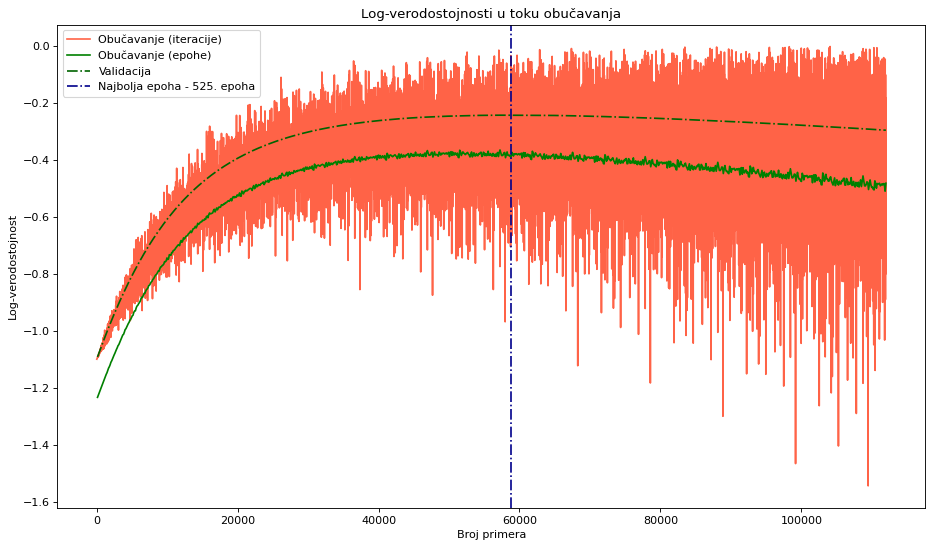

In [17]:
# ucitavanje podataka
X, y = read_data()

# podela podataka na trening i test skup
X_train, y_train, X_test, y_test = train_test_data_split(X, y, split_ratio=0.8)

# podela trening podataka na trening i validacioni skup
X_train, y_train, X_val, y_val = train_test_data_split(X_train, y_train, split_ratio=0.8)

best_theta, _ = train(X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=12, lr=0.001, expand=True)

# Implementacija funckija za prikaz metrika

In [23]:
def get_confusion_matrix(y: np.ndarray, y_hat: np.ndarray, labels: list) -> None:

    cm = confusion_matrix(y, y_hat, labels = labels)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_disp.plot()

# Evaluacija Softmax modela

Accuracy - Trening:     0.6785714285714286
Accuracy - Validacija:  0.6551724137931034
Accuracy - Test:        0.5277777777777778


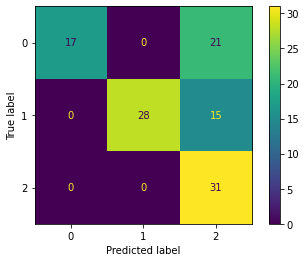

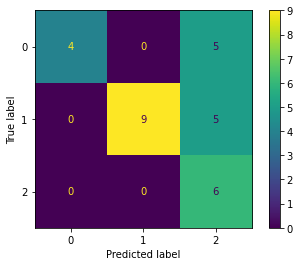

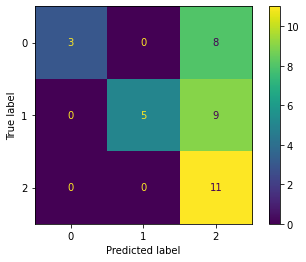

In [25]:
y_hat_train = predict(X_train, best_theta, expand=True)

cnt = 0
for i, y in enumerate(y_hat_train):
    if y == y_train[i]:
        cnt += 1
        
print('Accuracy - Trening:     ' + str(cnt / y_train.size))
get_confusion_matrix(y_train, y_hat_train, [0,1,2])

y_hat_val = predict(X_val, best_theta, expand=True)

cnt = 0
for i, y in enumerate(y_hat_val):
    if y == y_val[i]:
        cnt += 1
        
print('Accuracy - Validacija:  ' + str(cnt / y_val.size))
get_confusion_matrix(y_val, y_hat_val, [0,1,2])

y_hat_test = predict(X_test, best_theta, expand=True)

cnt = 0
for i, y in enumerate(y_hat_test):
    if y == y_test[i]:
        cnt += 1
        
print('Accuracy - Test:        ' + str(cnt / y_test.size))
get_confusion_matrix(y_test, y_hat_test, [0,1,2])